<a href="https://colab.research.google.com/github/iamnarendran/Transformer-from-scratch/blob/main/Transformer_from_Stratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transformer from stratch:**

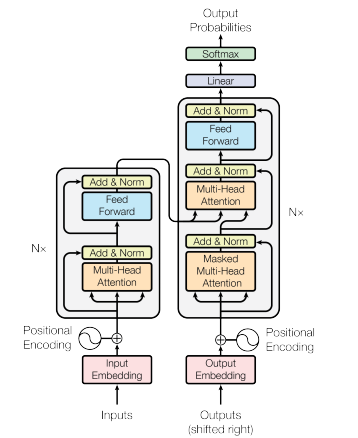

**Importing dependency (`torch & nn`)**


```
import torch
import torch.nn as nn
```


**The class "`SelfAttention`" defines a multi-head self-attention module, and inherits from PyTorch's base class nn.Module.**

`embed_size`: the size of each token’s embedding (e.g., 512).

`heads`: the number of attention heads (e.g., 8).

`self.head_dim` is the size of the embedding for each head.

> For example in this project:
If embed_size = 256 and heads = 8, then head_dim = 64.

on `assert` : total split embedding should match the original size. Else the model won't reconstruct the shape after multi-head merging


```
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"
```

**Each head will have its own:**

**`Query`: What am I looking for?**

**`Key`: What do I offer?**

**`Value`: What info to send if selected**

for `fc_out`:
After attention is done across all heads, you concatenate the outputs from each head, and pass it through a final linear layer to mix them.This gives you back a tensor of the original embed_size shape.
```
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)


this block is the core logic of self-attention, we started with the `forward` func which extracts the sequence lengths for value, key, and query inputs.



```
def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]
```
Now the shape becomes:

[
𝑁
,
𝑠
𝑒
𝑞
_
𝑙
𝑒
𝑛
,
ℎ
𝑒
𝑎
𝑑
𝑠
,
ℎ
𝑒
𝑎
𝑑
_
𝑑
𝑖
𝑚
]

This separates each token's embedding across multiple heads. You now have multi-head attention.


```
values = values.reshape(N, value_len, self.heads, self.head_dim)
keys = keys.reshape(N, key_len, self.heads, self.head_dim)
query = query.reshape(N, query_len, self.heads, self.head_dim)

```
Each of these is passed through its own linear layer to get:

- Values V

- Keys K

- Queries Q

Still in [N, seq_len, heads, head_dim] format.

```
values = self.values(values)
keys = self.keys(keys)
queries = self.queries(query)

```
This does a dot product between Q and K^T:

n: batch

q: query position

k: key position

h: head

d: head dimension

Output shape: [N, heads, query_len, key_len]

```
energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
```

If mask == 0, set score to a huge negative number, so after softmax it becomes near zero.

This is used for padding or causal (decoder) masking.


```
if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))          
```
Apply softmax along the key dimension (dim=3) to normalize attention scores.

Dividing by sqrt(embed size) is for scaling (as in original paper).
```
attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
```
You now multiply the attention weights with the value vectors:

attention: how much to pay attention to each key

values: the actual content to pass through

Output shape: [N, query_len, heads, head_dim]

```
 out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
```
Flatten the last two dimensions back to [N, query_len, embed_size]

Pass through final linear layer fc_out to mix heads.

```
 out = self.fc_out(out)
        return out
```

## **The class `Transformer`**

The class `Transformer` defines one complete transformer layer consisting of multi-head self-attention, residual connections, normalization, and feed-forward processing.

**Components:**

- `SelfAttention(embed_size, heads)` — multi-head attention mechanism  
- `LayerNorm` — stabilizes training and accelerates convergence  
- `forward_expansion` — expands dimensions in the feed-forward sublayer (usually 4× the embed size)  
- `Dropout` — helps prevent overfitting

After attention is done and residual connection is applied, the layer processes the result with a feed-forward network and normalizes again.


```
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)

        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

```
On this forward func of transformer block we do:

1. Attention output is added to the input (query) — this is a residual connection.

2. LayerNorm smooths the distribution.

3. Then, the result is passed through a feed-forward network (FFN).

4. Again, a residual connection is added and normalized.


```
    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(attention + query))  # Residual + Norm
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))      # Residual + Norm
        return out

```



## **The class `Encoder`**

> The `Encoder` is for processing the input sequence and turning it into meaningful representations that the decoder can use.
> It stacks multiple `TransformerBlock`s together, and each one captures increasingly higher-level features of the input sequence.

## Components:

- **`embed_size`**: Size of token embeddings (e.g., 256)
- **`src_vocab_size`**: Size of source vocabulary
- **`max_length`**: Maximum sequence length for positional encoding
- **`TokenEmbedding`**: Learns vector representations for each token
- **`PositionalEncoding`**: Injects order information into the model
- **`TransformerBlock`**: Repeated attention + feed-forward layer
- **`dropout`**: Regularization to prevent overfitting


The encoder processes the input like this:
1. Input tokens are embedded and added with positional encodings
2. The result passes through multiple transformer blocks



```
class Encoder(nn.Module):
  def __init__(self, src_vocab_size, embed_size, num_layers, heads, device, forward_expansion, dropout, max_length):
    super(Encoder, self).__init__()
    self.embed_size = embed_size
    self.device = device
    self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
    self.position_embedding = nn.Embedding(max_length, embed_size)
    self.layers = nn.ModuleList(
        [
            TransformerBlock(
                embed_size,
                heads,
                dropout=dropout,
                forward_expansion=forward_expansion,
            )
            for _ in range(num_layers)
        ]
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask):
    N, seq_length = x.shape
    positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
    out = self.dropout(
        (self.word_embedding(x) + self.position_embedding(positions))
    )


    for layer in self.layers:
        out = layer(out, out, out, mask)

    return out
```

- "Each Encoder layer is a TransformerBlock that applies multi-head self-attention followed by a feed-forward network."

- "The input is embedded and enriched with position info before passing through these layers."

- "All K, Q, and V come from the same input in the encoder — this is what makes it self-attention."


##**The class `DecoderBlock`**

The `DecoderBlock` is the key unit used in the decoder. It has **two attention layers**:

1. **Masked Self-Attention** (to look only at previous tokens)
2. **Encoder-Decoder Attention** (to attend over encoder outputs)
 This lets the decoder generate one token at a time, attending to both previously generated tokens and the full encoder output.


## Components Breakdown:

- **`SelfAttention(embed_size, heads)`** → Used twice:
  - `self.attention` → masked self-attention (on decoder's previous output)
  - `self.cross_attention` → encoder-decoder attention (queries from decoder, keys/values from encoder)
- **`LayerNorm`** → Applied after each residual connection
- **`Dropout`** → For regularization
- **`feed_forward`** → MLP after attention


```
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)  # Masked Self-Attention
        self.norm = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.cross_attention = SelfAttention(embed_size, heads)  # Encoder-Decoder Attention
        self.norm3 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )

        self.dropout = nn.Dropout(dropout)

```

## Forward Flow:

1. First attention is **masked** — so decoder can’t look ahead
2. Second attention layer allows decoder to **attend to encoder outputs**
3. Feed-forward network enhances non-linear transformations
4. Every block has **residual connections + layer normalization**

This block allows autoregressive generation and context-aware decoding.


```
    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))  # Residual + Norm
        
        attention = self.cross_attention(value, key, query, src_mask)
        out = self.dropout(self.norm2(attention + query))  # Residual + Norm

        
        forward = self.feed_forward(out)
        out = self.dropout(self.norm3(forward + out))  # Residual + Norm

        return out
```




This is the main Transformer Class, this class will bring together the Encoder, Decoder, and all related configs into one unified model.

This is the constructor (__init__) for the Transformer class. It initializes all the required components and hyperparameters.

- `src_vocab_size`: Vocabulary size of the source/input language (e.g., English)

- `trg_vocab_size`: Vocabulary size of the target/output language (e.g., French)

- `src_pad_idx` and `trg_pad_idx`: Index used for padding in source/target sequences

- `embed_size`: Embedding dimension for tokens (default: 256)

- `num_layers`: Number of stacked transformer blocks in encoder and decoder

- `forward_expansion`: Multiplier for hidden dimension size inside feed-forward layers

- `heads`: Number of attention heads for multi-head attention

- `dropout`: Dropout probability to prevent overfitting

- `device`: Where to run the model (cuda for GPU, or cpu)

- `max_length`: Maximum length of input/output sequences




```
class Transformer(nn.Module):
  def __init__(
      self,
      src_vocab_size,
      trg_vocab_size,
      src_pad_idx,
      trg_pad_idx,
      embed_size=256,
      num_layers=6,
      forward_expansion=4,
      heads=8,
      dropout=0,
      device="cuda",
      max_length=100
  ):

```
The encoder module using the earlier-defined Encoder class.

It takes the source vocab size, embedding config, device, number of layers, etc.

Internally, the encoder will stack multiple TransformerBlocks and apply token/position embedding.

```
    super(Transformer, self).__init__()
    self.encoder = Encoder(
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    )
```



the Decoder component using the previously defined Decoder class.

`trg_vocab_size`: Size of the target language vocabulary.

`embed_size`: Embedding dimension used across decoder layers.

`num_layers`: Number of decoder blocks (same as encoder).

`heads`: Number of attention heads in each decoder block.

`forward_expansion`: Hidden layer expansion in FFN.

`dropout`: For regularization.

`device`: Whether running on CPU or GPU.

`max_length`: Maximum length of output sequence.

The decoder will take in the target sequence (e.g., in French) and:

Attend to itself via masked self-attention

Attend to the encoder’s output via encoder-decoder attention

This allows the decoder to predict one token at a time, using both:

- What it has already generated

- What the encoder understood from the input
```
    self.decoder = Decoder(
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    )

    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device
```

- The source mask ensures that PAD tokens in the input sequence are ignored during attention.

- src != self.src_pad_idx creates a boolean mask (True for real tokens, False for padding).

- unsqueeze(1) and unsqueeze(2) reshape it to shape:
[batch_size, 1, 1, src_len], which is compatible with attention.

- The result is a binary mask: 1 for valid tokens, 0 for PAD.

- Finally, it moves the mask to the correct device (cuda or cpu)

```
  def make_src_mask(self, src):
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    return src_mask.to(self.device)
```

- This creates a causal mask (lower triangular matrix) to prevent the decoder from attending to future tokens.

- torch.tril(...) creates a lower triangle of 1s — top-right is zeroed out.

- .expand(N, 1, trg_len, trg_len) copies this for each item in the batch.

- This ensures auto-regressive decoding — the decoder can only see previous tokens.

- Like the source mask, it is sent to the right device.

```
  def make_trg_mask(self, trg):
    N, trg_len = trg.shape
    trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
        N, 1, trg_len, trg_len
    )
    return trg_mask.to(self.device)

```

## Forward Pass – `Transformer.forward()`

The `forward()` this is how input flows through the entire Transformer model during training or inference.


## Inputs:
- `src`: Source token sequence (e.g., input sentence in English)
- `trg`: Target token sequence (e.g., output sentence in French)
- `src_mask`: Mask to ignore padding tokens in the source
- `trg_mask`: Causal mask to prevent decoder from seeing future tokens


##Steps:
1. Pass `src` through the **encoder** → get encoded representations
2. Pass `trg` and encoder output into the **decoder**
3. Decoder uses:
   - Masked self-attention (with `trg_mask`)
   - Cross-attention to encoder output (with `src_mask`)
4. Return the decoder's final output


```
  def forward(self, src, trg):
    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)
    enc_src = self.encoder(src, src_mask)
    out = self.decoder(trg, enc_src, src_mask, trg_mask)
    return out
```

# **Entire Code block ⏬**

In [ ]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query) # Corrected typo here

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)

        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class Encoder(nn.Module):
  def __init__(self, src_vocab_size, embed_size, num_layers, heads, device, forward_expansion, dropout, max_length):
    super(Encoder, self).__init__()
    self.embed_size = embed_size
    self.device = device
    self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
    self.position_embedding = nn.Embedding(max_length, embed_size)
    self.layers = nn.ModuleList(
        [
            TransformerBlock(
                embed_size,
                heads,
                dropout=dropout,
                forward_expansion=forward_expansion,
            )
            for _ in range(num_layers)
        ]
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask):
    N, seq_length = x.shape
    positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
    out = self.dropout(
        (self.word_embedding(x) + self.position_embedding(positions))
    )


    for layer in self.layers:
        out = layer(out, out, out, mask)

    return out

class DecoderBlock(nn.Module):
  def __init__(self, embed_size, heads, forward_expansion, dropout, device):
    super(DecoderBlock, self).__init__()
    self.norm = nn.LayerNorm(embed_size)
    self.attention = SelfAttention(embed_size, heads=heads)
    self.transformer_block = TransformerBlock(
        embed_size, heads, dropout, forward_expansion
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, value, key, src_mask, trg_mask):
    attention = self.attention(x, x, x, trg_mask)
    query = self.dropout(self.norm(attention + x))
    out = self.transformer_block(value, key, query, src_mask)
    return out

class Decoder(nn.Module):
  def __init__(self, trg_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, device, max_length):
    super(Decoder, self).__init__()
    self.device = device
    self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
    self.position_embedding = nn.Embedding(max_length, embed_size)

    self.layers = nn.ModuleList(
        [DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
         for _ in range(num_layers)]
    )

    self.fc_out = nn.Linear(embed_size, trg_vocab_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, enc_out, src_mask, trg_mask):
    N, seq_length = x.shape
    positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
    x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))

    for layer in self.layers:
        x = layer(x, enc_out, enc_out, src_mask, trg_mask)

    out = self.fc_out(x)
    return out

class Transformer(nn.Module):
  def __init__(
      self,
      src_vocab_size,
      trg_vocab_size,
      src_pad_idx,
      trg_pad_idx,
      embed_size=256,
      num_layers=6,
      forward_expansion=4,
      heads=8,
      dropout=0,
      device="cuda",
      max_length=100
  ):
    super(Transformer, self).__init__()
    self.encoder = Encoder(
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    )

    self.decoder = Decoder(
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    )

    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device

  def make_src_mask(self, src):
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    return src_mask.to(self.device)

  def make_trg_mask(self, trg):
    N, trg_len = trg.shape
    trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
        N, 1, trg_len, trg_len
    )
    return trg_mask.to(self.device)

  def forward(self, src, trg):
    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)
    enc_src = self.encoder(src, src_mask)
    out = self.decoder(trg, enc_src, src_mask, trg_mask)
    return out

In [ ]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(
        device
    )
    trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0], [1, 5, 6, 2, 4, 7, 6, 2]]).to(device)

    src_pad_idx = 0
    trg_pad_idx = 0
    src_vocab_size = 10
    trg_vocab_size = 10
    model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device).to(
        device
    )
    out = model(x, trg[:, :-1])
    print(out.shape)

torch.Size([2, 7, 10])
